# Building The StarTrack Model - 2

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch.nn.functional as F
import copy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
tabular_data = pd.read_csv('../data/processed_data.csv')
pd.set_option('display.max_columns', None)
tabular_data.head()

,Unnamed: 0.1,Unnamed: 0,PLATE,MJD,FIBERID,CLASS,SUBCLASS,ELODIE_SPTYPE,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,Z,Z_ERR,ZWARNING,VDISP,VDISP_ERR,SN_MEDIAN_ALL,RCHI2,DOF,SUBCLASS_CLEAN,SPECTRAL_GROUP,SNR_Bin,High_Quality,Mean_Flux,Flux_to_Noise,u_flux,g_flux,r_flux,i_flux,z_flux,flux_mean,flux_std,flux_min,flux_max,flux_median,flux_p25,flux_p75
0,1,21,266,51602,22,STAR,WD,A0,7652.0,4.287,0.06,-0.000203,0.000017,0,0.0,0.0,35.487301,1.592232,3763,WD,WD,Good,False,186.603329,5.258313,0.122004,0.019352,-0.022279,-0.025010,-0.018879,186.603329,31.226214,142.713699,225.408386,189.586014,160.894745,214.413803
1,2,27,266,51602,28,STAR,F2,F9V,6038.0,4.370,-0.08,-0.000031,0.000008,0,0.0,0.0,35.359707,1.594363,3750,F2,F,Good,False,241.821964,6.838913,0.163460,0.027785,-0.014652,-0.018542,-0.014578,241.821964,35.124660,172.687210,265.467377,261.459534,247.324982,262.170715
2,3,28,266,51602,29,STAR,WD,unknown,9000.0,4.000,-2.50,0.000603,0.000177,0,0.0,0.0,2.225974,1.139563,3742,WD,WD,Very Low,False,4.449317,1.998818,-0.070436,-0.064762,-0.055695,-0.040814,-0.025653,4.449317,1.465356,2.503016,6.811224,4.174976,3.577307,5.180061
3,4,30,266,51602,31,STAR,WD,unknown,9000.0,4.000,-2.50,-0.000037,0.000088,0,0.0,0.0,7.260117,1.147462,3771,WD,WD,Low,False,20.110715,2.770026,-0.054230,-0.057813,-0.052901,-0.039429,-0.025021,20.110715,3.477413,15.293794,24.869940,20.418892,17.294498,22.676453
4,5,31,266,51602,32,STAR,G2,G1V,5613.0,4.110,-0.94,0.000218,0.000010,0,0.0,0.0,36.094147,1.042492,3764,G2,G,Good,True,246.397417,6.826520,0.015442,-0.008332,-0.013022,-0.011457,-0.009000,246.397417,121.315114,65.667641,391.897797,272.376373,153.463730,348.581543


In [4]:
columns_to_drop = ["Unnamed: 0", "Unnamed: 0.1", 
                   "CLASS", "SUBCLASS", "SUBCLASS_CLEAN", "SPECTRAL_GROUP", 
                   "PLATE", "MJD", "FIBERID", "ELODIE_SPTYPE" ]
labels_tabular = tabular_data["SPECTRAL_GROUP"]
tabular_data = tabular_data.drop(columns=columns_to_drop)
pd.set_option('display.max_columns', None)
bin_dict = {'Below 0': -1, 'Very Low': 0, 'Low': 1, 'Moderate': 2, 'Good': 3, 'High': 4, 'Very High': 5}
tabular_data["SNR_Bin"] = tabular_data["SNR_Bin"].map(bin_dict)
qual_dict = {False: 0, True: 1} # There's probably a better way to do this not going to lie
tabular_data["High_Quality"] = tabular_data["High_Quality"].map(qual_dict)
tabular_data.head()

,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,Z,Z_ERR,ZWARNING,VDISP,VDISP_ERR,SN_MEDIAN_ALL,RCHI2,DOF,SNR_Bin,High_Quality,Mean_Flux,Flux_to_Noise,u_flux,g_flux,r_flux,i_flux,z_flux,flux_mean,flux_std,flux_min,flux_max,flux_median,flux_p25,flux_p75
0,7652.0,4.287,0.06,-0.000203,0.000017,0,0.0,0.0,35.487301,1.592232,3763,3,0,186.603329,5.258313,0.122004,0.019352,-0.022279,-0.025010,-0.018879,186.603329,31.226214,142.713699,225.408386,189.586014,160.894745,214.413803
1,6038.0,4.370,-0.08,-0.000031,0.000008,0,0.0,0.0,35.359707,1.594363,3750,3,0,241.821964,6.838913,0.163460,0.027785,-0.014652,-0.018542,-0.014578,241.821964,35.124660,172.687210,265.467377,261.459534,247.324982,262.170715
2,9000.0,4.000,-2.50,0.000603,0.000177,0,0.0,0.0,2.225974,1.139563,3742,0,0,4.449317,1.998818,-0.070436,-0.064762,-0.055695,-0.040814,-0.025653,4.449317,1.465356,2.503016,6.811224,4.174976,3.577307,5.180061
3,9000.0,4.000,-2.50,-0.000037,0.000088,0,0.0,0.0,7.260117,1.147462,3771,1,0,20.110715,2.770026,-0.054230,-0.057813,-0.052901,-0.039429,-0.025021,20.110715,3.477413,15.293794,24.869940,20.418892,17.294498,22.676453
4,5613.0,4.110,-0.94,0.000218,0.000010,0,0.0,0.0,36.094147,1.042492,3764,3,1,246.397417,6.826520,0.015442,-0.008332,-0.013022,-0.011457,-0.009000,246.397417,121.315114,65.667641,391.897797,272.376373,153.463730,348.581543


In [5]:
cat_cols = ['ZWARNING', 'SNR_Bin', 'High_Quality', 'DOF']
numeric_cols = [col for col in tabular_data.columns if col not in cat_cols]
scaler = StandardScaler()
tabular_data_scaled_numeric = pd.DataFrame(scaler.fit_transform(tabular_data[numeric_cols]), columns=numeric_cols)
tabular_data_cat = tabular_data[cat_cols].reset_index(drop=True)

tabular_data_processed = pd.concat([tabular_data_scaled_numeric, tabular_data_cat], axis=1)
tabular_data_processed = tabular_data_processed[tabular_data.columns]

print(tabular_data_processed.head())

   ELODIE_TEFF  ELODIE_LOGG  ELODIE_FEH         Z     Z_ERR  ZWARNING  VDISP  \
0     1.701294     0.399468    0.793453 -0.168372 -0.002112         0    0.0   
1     0.527703     0.480184    0.620273  0.080864 -0.002112         0    0.0   
2     2.681467     0.120365   -2.373272  0.996701 -0.002106         0    0.0   
3     2.681467     0.120365   -2.373272  0.071959 -0.002109         0    0.0   
4     0.218672     0.227338   -0.443549  0.440732 -0.002112         0    0.0   

   VDISP_ERR  SN_MEDIAN_ALL     RCHI2   DOF  SNR_Bin  High_Quality  Mean_Flux  \
0        0.0       0.681625  0.024548  3763        3             0  -0.017712   
1        0.0       0.675176  0.025592  3750        3             0  -0.011066   
2        0.0      -0.999324 -0.197186  3742        0             0  -0.039636   
3        0.0      -0.744910 -0.193316  3771        1             0  -0.037751   
4        0.0       0.712293 -0.244735  3764        3             1  -0.010516   

   Flux_to_Noise    u_flux    g_

In [6]:
tabular_data_processed.shape

(802836, 27)

In [7]:
missing_per_column = tabular_data.isnull().sum()
print(missing_per_column[missing_per_column > 0]) 

Series([], dtype: int64)


In [8]:
labels_tabular.head()

0    WD
1     F
2    WD
3    WD
4     G
Name: SPECTRAL_GROUP, dtype: object

In [9]:
# Method taken from my EchoScope project, check it out here: https://github.com/blueskinlizard/EchoScope/tree/main
def split_sets(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)
    
    print(f'Train shape: {X_train.shape}, {y_train.shape}')
    print(f'Validation shape: {X_val.shape}, {y_val.shape}')
    print(f'Test shape: {X_test.shape}, {y_test.shape}')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
# Method also taken from EchoScope
def train_model(model, criterion, optimizer, epochs, train_loader, val_loader, patience=100, scheduler=None):
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_bar.set_postfix(loss=loss.item())
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for X_batch, y_batch in val_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_bar.set_postfix(loss=loss.item())
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
                break
        if scheduler:
            scheduler.step(val_loss)
            
    model.load_state_dict(best_model_state)
    return train_losses, val_losses

In [11]:
# Method also taken from EchoScope
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Training The Dense (Tabular Data) branch

In [12]:
le_tabular = LabelEncoder()
labels_encoded_tabular = le_tabular.fit_transform(labels_tabular)
X = tabular_data_processed
y = labels_encoded_tabular
print("X shape:", X.shape)
print(f'Total samples: {X.shape[0]}')
print(f'Unique classes: {le_tabular.classes_}')

X shape: (802836, 27)
Total samples: 802836
Unique classes: ['A' 'B' 'F' 'G' 'K' 'L' 'M' 'WD']


In [13]:
print(f'X shape: {X.shape}, y shape: {len(y)}')

X shape: (802836, 27), y shape: 802836


In [14]:
X_table_train, y_table_train, X_table_val, y_table_val, X_table_test, y_table_test = split_sets(X, y)

Train shape: (513814, 27), (513814,)
Validation shape: (128454, 27), (128454,)
Test shape: (160568, 27), (160568,)


In [15]:
X_table_train_fusion = X_table_train.copy()
X_table_val_fusion = X_table_val.copy()
X_table_test_fusion = X_table_test.copy()

y_table_train_fusion = y_table_train.copy()
y_table_val_fusion = y_table_val.copy()
y_table_test_fusion = y_table_test.copy()

In [16]:
train_dataset_table_np = torch.utils.data.TensorDataset(
    torch.tensor(X_table_train.values, dtype=torch.float32),
    torch.tensor(y_table_train, dtype=torch.long)
)

val_dataset_table_np = torch.utils.data.TensorDataset(
    torch.tensor(X_table_val.values, dtype=torch.float32),
    torch.tensor(y_table_val, dtype=torch.long)
)

test_dataset_table_np = torch.utils.data.TensorDataset(
    torch.tensor(X_table_test.values, dtype=torch.float32),
    torch.tensor(y_table_test, dtype=torch.long)
)

In [17]:
train_loader_tabular = DataLoader(train_dataset_table_np, batch_size=512, shuffle=True)
val_loader_tabular = DataLoader(val_dataset_table_np, batch_size=512, shuffle=False)
test_loader_tabular = DataLoader(test_dataset_table_np, batch_size=512, shuffle=True)

In [23]:
class StarTrack_Dense(nn.Module):
    def __init__(self, input_size=27, hidden_sizes=[1024, 512, 512, 256, 128], output_size=8):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])

        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(hidden_sizes[2], output_size)
        self.act = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x1 = self.act(self.bn1(self.fc1(x)))
        x1 = self.dropout(x1)
        x2 = self.act(self.bn2(self.fc2(x1)))
        x2 = self.dropout(x2)
        x3 = self.act(self.bn3(self.fc3(x2)))
        x3 = self.dropout(x3)

        return self.out(x3)


In [24]:
StarTrack_Dense_V1 = StarTrack_Dense()
StarTrack_Dense_V1 = StarTrack_Dense_V1 .to(device)

In [25]:
class_weights_dense = [3.26123439, 8.32599819, 1.23, 1.50887445, 1.03, 6.5624553, 1.33, 3.30963362]
print(class_weights_dense)
class_weights_dense = torch.tensor(class_weights_dense, dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_dense)
optimizer_dense = torch.optim.Adam(StarTrack_Dense_V1.parameters(), lr=5e-4, weight_decay=5e-4)
scheduler_dense = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_dense, mode='min', factor=0.1, patience=5)

[3.26123439, 8.32599819, 1.23, 1.50887445, 1.03, 6.5624553, 1.33, 3.30963362]


In [26]:
train_losses_dense, val_losses_dense = train_model(model=StarTrack_Dense_V1, 
                                       criterion=loss_fn, 
                                       optimizer=optimizer_dense, 
                                       epochs=50, 
                                       train_loader=train_loader_tabular, 
                                       val_loader=val_loader_tabular,
                                       scheduler=scheduler_dense)

Epoch 1/50 | Train Loss: 1.006136 | Val Loss: 2.697069


Epoch 2/50 | Train Loss: 0.841421 | Val Loss: 1.957824


Epoch 3/50 | Train Loss: 0.806705 | Val Loss: 1.273688


Epoch 4/50 | Train Loss: 0.782881 | Val Loss: 2.289467


Epoch 5/50 | Train Loss: 0.768949 | Val Loss: 4.098403


Epoch 6/50 | Train Loss: 0.754068 | Val Loss: 3.287696


Epoch 7/50 | Train Loss: 0.746564 | Val Loss: 1.839757


Epoch 8/50 | Train Loss: 0.742738 | Val Loss: 2.136098


Epoch 9/50 | Train Loss: 0.735715 | Val Loss: 3.359197


Epoch 10/50 | Train Loss: 0.697520 | Val Loss: 0.709798


Epoch 11/50 | Train Loss: 0.686864 | Val Loss: 0.750152


Epoch 12/50 | Train Loss: 0.681434 | Val Loss: 0.909592


Epoch 13/50 | Train Loss: 0.681176 | Val Loss: 0.679768


Epoch 14/50 | Train Loss: 0.675984 | Val Loss: 0.825783


Epoch 15/50 | Train Loss: 0.674202 | Val Loss: 0.787497


Epoch 16/50 | Train Loss: 0.672885 | Val Loss: 0.827055


Epoch 17/50 | Train Loss: 0.670045 | Val Loss: 0.880297


Epoch 18/50 | Train Loss: 0.667097 | Val Loss: 0.700229


Epoch 19/50 | Train Loss: 0.666445 | Val Loss: 0.803665


Epoch 20/50 | Train Loss: 0.661523 | Val Loss: 0.623679


Epoch 21/50 | Train Loss: 0.659326 | Val Loss: 0.624332


Epoch 22/50 | Train Loss: 0.658528 | Val Loss: 0.620301


Epoch 23/50 | Train Loss: 0.658469 | Val Loss: 0.623500


Epoch 24/50 | Train Loss: 0.657362 | Val Loss: 0.619859


Epoch 25/50 | Train Loss: 0.657730 | Val Loss: 0.622581


Epoch 26/50 | Train Loss: 0.656571 | Val Loss: 0.629457


Epoch 27/50 | Train Loss: 0.656540 | Val Loss: 0.620563


Epoch 28/50 | Train Loss: 0.656371 | Val Loss: 0.624093


Epoch 29/50 | Train Loss: 0.655637 | Val Loss: 0.620822


Epoch 30/50 | Train Loss: 0.655884 | Val Loss: 0.615242


Epoch 31/50 | Train Loss: 0.656536 | Val Loss: 0.627664


Epoch 32/50 | Train Loss: 0.655624 | Val Loss: 0.626232


Epoch 33/50 | Train Loss: 0.655560 | Val Loss: 0.619873


Epoch 34/50 | Train Loss: 0.655077 | Val Loss: 0.624190


Epoch 35/50 | Train Loss: 0.656307 | Val Loss: 0.617147


Epoch 36/50 | Train Loss: 0.654462 | Val Loss: 0.621622


Epoch 37/50 | Train Loss: 0.653815 | Val Loss: 0.616366


Epoch 38/50 | Train Loss: 0.653877 | Val Loss: 0.616860


Epoch 39/50 | Train Loss: 0.654011 | Val Loss: 0.617387


Epoch 40/50 | Train Loss: 0.652960 | Val Loss: 0.616440


Epoch 41/50 | Train Loss: 0.653504 | Val Loss: 0.615780


Epoch 42/50 | Train Loss: 0.652833 | Val Loss: 0.638975


Epoch 43/50 | Train Loss: 0.654364 | Val Loss: 0.615403


Epoch 44/50 | Train Loss: 0.653662 | Val Loss: 0.615317


Epoch 45/50 | Train Loss: 0.653691 | Val Loss: 0.616125


Epoch 46/50 | Train Loss: 0.652845 | Val Loss: 0.617751


Epoch 47/50 | Train Loss: 0.653883 | Val Loss: 0.624867


Epoch 48/50 | Train Loss: 0.654395 | Val Loss: 0.615947


Epoch 49/50 | Train Loss: 0.653831 | Val Loss: 0.614474


Epoch 50/50 | Train Loss: 0.653957 | Val Loss: 0.628526


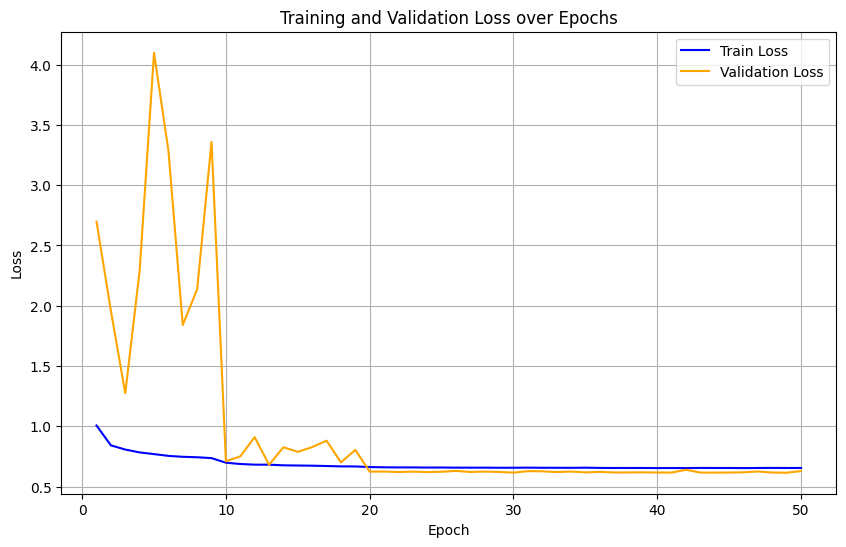

In [27]:
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses_dense, val_losses_dense)

In [28]:
def evaluate_model(model, data_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {acc:.4f}')
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
    return all_labels, all_preds 

In [29]:
y_table_true, y_table_pred = evaluate_model(StarTrack_Dense_V1, test_loader_tabular, device, le_tabular)

Accuracy: 0.7980
Classification Report:
              precision    recall  f1-score   support

           A       0.36      0.58      0.44      6155
           B       0.36      0.48      0.41      2411
           F       0.87      0.83      0.85     71213
           G       0.54      0.58      0.56     13302
           K       0.90      0.83      0.87     30126
           L       0.44      0.75      0.56      3058
           M       0.94      0.88      0.91     28238
          WD       0.72      0.67      0.69      6065

    accuracy                           0.80    160568
   macro avg       0.64      0.70      0.66    160568
weighted avg       0.82      0.80      0.81    160568



In [30]:
def get_preds_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_preds), torch.cat(all_labels)

In [31]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
        
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

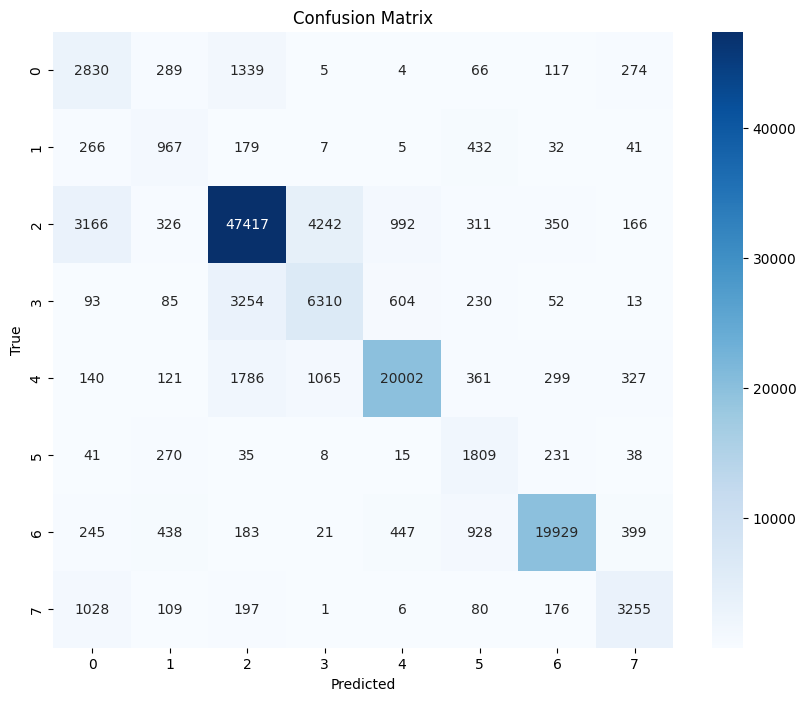

In [32]:
y_pred, y_true = get_preds_labels(StarTrack_Dense_V1, val_loader_tabular, device)

plot_confusion_matrix(y_true, y_pred)

In [33]:
torch.save(StarTrack_Dense_V1.state_dict(), 'dense_model_full.pth')

# Training The LSTM (Spectrogram) Branch

In [34]:
spectrogram_data = np.load('../data/startrack_spectrograms.npz', allow_pickle=True)
print(spectrogram_data.files)

['spectrograms', 'labels']


In [35]:
le_spect = LabelEncoder()
labels_encoded_spect = le_spect.fit_transform(spectrogram_data['labels'])
X = spectrogram_data['spectrograms']
X = X.reshape((X.shape[0], X.shape[1], 1))
y = labels_encoded_spect
print("X shape:", X.shape)
print(f'Total samples: {X.shape[0]}')
print(f'Unique classes: {le_spect.classes_}')

X shape: (24782, 1024, 1)
Total samples: 24782
Unique classes: ['A' 'B' 'CV' 'F' 'G' 'K' 'L' 'M' 'WD']


In [36]:
X_spect_train, y_spect_train, X_spect_val, y_spect_val, X_spect_test, y_spect_test = split_sets(X, y)

Train shape: (15860, 1024, 1), (15860,)
Validation shape: (3965, 1024, 1), (3965,)
Test shape: (4957, 1024, 1), (4957,)


In [37]:
X_spect_train_fusion = X_spect_train.copy()
X_spect_val_fusion = X_spect_val.copy()
X_spect_test_fusion = X_spect_test.copy()

y_spect_train_fusion = y_spect_train.copy()
y_spect_val_fusion = y_spect_val.copy()
y_spect_test_fusion = y_spect_test.copy()

In [38]:
train_dataset_spect = TensorDataset(torch.tensor(X_spect_train, dtype=torch.float32), torch.tensor(y_spect_train, dtype=torch.long))
val_dataset_spect = TensorDataset(torch.tensor(X_spect_val, dtype=torch.float32), torch.tensor(y_spect_val, dtype=torch.long))
test_dataset_spect = TensorDataset(torch.tensor(X_spect_test, dtype=torch.float32), torch.tensor(y_spect_test, dtype=torch.long))

train_loader_spect = DataLoader(train_dataset_spect, batch_size=64, shuffle=True)
val_loader_spect = DataLoader(val_dataset_spect, batch_size=64, shuffle=False)
test_loader_spect = DataLoader(test_dataset_spect, batch_size=64, shuffle=False)

In [39]:
# Dataloader needs (B, 1024, 1) shape
class StarTrack_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, output_size=9, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            dropout=0.5, # Lower/Increase based off testing results
            batch_first=True
        )
        self.bn = nn.BatchNorm1d(hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def extract_features(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        return x
        
# Number of classes after grouping = 9

In [40]:
StarTrack_LSTM_V1 = StarTrack_LSTM()
StarTrack_LSTM_V1 = StarTrack_LSTM_V1 .to(device)

In [41]:
class_weights_LSTM = [0.9037037, 6.72603902, 2.5, 0.45, 1.83183183, 1.2, 10.12771392, 0.95, 2.48901444]
print(class_weights_LSTM)
class_weights_LSTM = torch.tensor(class_weights_LSTM, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_LSTM)
optimizer_LSTM = torch.optim.Adam(StarTrack_LSTM_V1.parameters(), lr=1e-4, weight_decay=1e-4)

[0.9037037, 6.72603902, 2.5, 0.45, 1.83183183, 1.2, 10.12771392, 0.95, 2.48901444]


In [42]:
train_losses_LSTM, val_losses_LSTM= train_model(model=StarTrack_LSTM_V1, 
                                       criterion=loss_fn, 
                                       optimizer=optimizer_LSTM, 
                                       epochs=50, 
                                       train_loader=train_loader_spect, 
                                       val_loader=val_loader_spect)

Epoch 1/50 | Train Loss: 2.005235 | Val Loss: 1.774021


Epoch 2/50 | Train Loss: 1.635611 | Val Loss: 1.472226


Epoch 3/50 | Train Loss: 1.496995 | Val Loss: 1.366740


Epoch 4/50 | Train Loss: 1.461142 | Val Loss: 1.960277


Epoch 5/50 | Train Loss: 1.402196 | Val Loss: 1.437093


Epoch 6/50 | Train Loss: 1.378495 | Val Loss: 1.264419


Epoch 7/50 | Train Loss: 1.387362 | Val Loss: 1.315511


Epoch 8/50 | Train Loss: 1.330034 | Val Loss: 1.399184


Epoch 9/50 | Train Loss: 1.312675 | Val Loss: 1.182051


Epoch 10/50 | Train Loss: 1.266324 | Val Loss: 1.214506


Epoch 11/50 | Train Loss: 1.238438 | Val Loss: 1.353815


Epoch 12/50 | Train Loss: 1.245847 | Val Loss: 1.159976


Epoch 13/50 | Train Loss: 1.221710 | Val Loss: 1.350056


Epoch 14/50 | Train Loss: 1.219829 | Val Loss: 1.207499


Epoch 15/50 | Train Loss: 1.183232 | Val Loss: 1.113732


Epoch 16/50 | Train Loss: 1.230998 | Val Loss: 1.162238


Epoch 17/50 | Train Loss: 1.167118 | Val Loss: 1.300394


Epoch 18/50 | Train Loss: 1.162626 | Val Loss: 1.120692


Epoch 19/50 | Train Loss: 1.162581 | Val Loss: 1.314553


Epoch 20/50 | Train Loss: 1.192243 | Val Loss: 1.191080


Epoch 21/50 | Train Loss: 1.165838 | Val Loss: 1.880682


Epoch 22/50 | Train Loss: 1.159767 | Val Loss: 1.110020


Epoch 23/50 | Train Loss: 1.141137 | Val Loss: 1.853345


Epoch 24/50 | Train Loss: 1.146758 | Val Loss: 1.595537


Epoch 25/50 | Train Loss: 1.138905 | Val Loss: 1.152809


Epoch 26/50 | Train Loss: 1.137437 | Val Loss: 1.111590


Epoch 27/50 | Train Loss: 1.124996 | Val Loss: 1.107791


Epoch 28/50 | Train Loss: 1.108496 | Val Loss: 1.153880


Epoch 29/50 | Train Loss: 1.115954 | Val Loss: 1.306392


Epoch 30/50 | Train Loss: 1.111865 | Val Loss: 1.269579


Epoch 31/50 | Train Loss: 1.097503 | Val Loss: 1.618341


Epoch 32/50 | Train Loss: 1.123146 | Val Loss: 1.262981


Epoch 33/50 | Train Loss: 1.119251 | Val Loss: 1.044081


Epoch 34/50 | Train Loss: 1.098494 | Val Loss: 1.721826


Epoch 35/50 | Train Loss: 1.086818 | Val Loss: 1.043072


Epoch 36/50 | Train Loss: 1.099675 | Val Loss: 1.063135


Epoch 37/50 | Train Loss: 1.077694 | Val Loss: 1.099530


Epoch 38/50 | Train Loss: 1.084581 | Val Loss: 2.504361


Epoch 39/50 | Train Loss: 1.072595 | Val Loss: 1.075672


Epoch 40/50 | Train Loss: 1.082601 | Val Loss: 1.150807


Epoch 41/50 | Train Loss: 1.074887 | Val Loss: 1.042044


Epoch 42/50 | Train Loss: 1.070366 | Val Loss: 1.446527


Epoch 43/50 | Train Loss: 1.068215 | Val Loss: 1.002797


Epoch 44/50 | Train Loss: 1.114497 | Val Loss: 1.108565


Epoch 45/50 | Train Loss: 1.073726 | Val Loss: 1.047596


Epoch 46/50 | Train Loss: 1.049868 | Val Loss: 1.695279


Epoch 47/50 | Train Loss: 1.060166 | Val Loss: 1.614877


Epoch 48/50 | Train Loss: 1.053566 | Val Loss: 1.145159


Epoch 49/50 | Train Loss: 1.068175 | Val Loss: 1.203373


Epoch 50/50 | Train Loss: 1.048058 | Val Loss: 1.104165


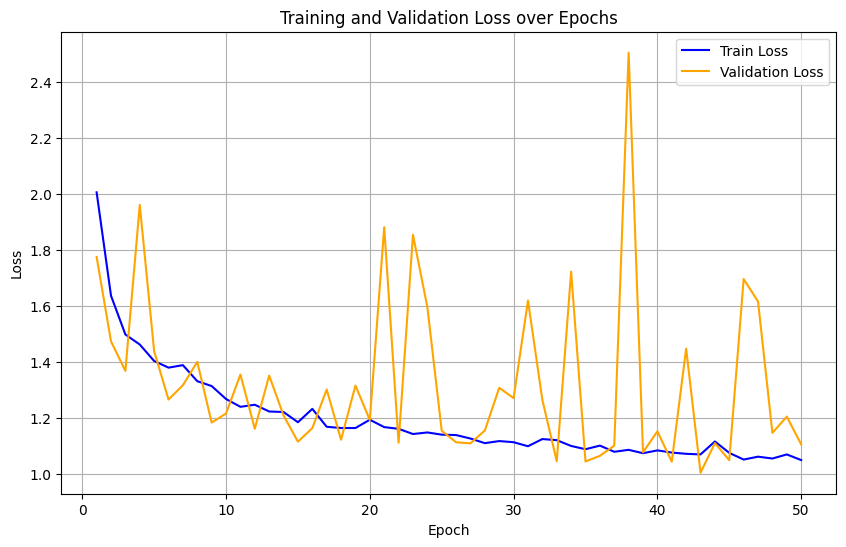

In [43]:
plot_losses(train_losses_LSTM, val_losses_LSTM)

In [26]:
y_spect_true, y_spect_pred = evaluate_model(StarTrack_LSTM_V1, test_loader_spect, device, le_spect)

Accuracy: 0.5963
Classification Report:
              precision    recall  f1-score   support

           A       0.31      0.49      0.38       609
           B       0.13      0.22      0.17        82
          CV       0.78      0.52      0.63       298
           F       0.88      0.50      0.64      2042
           G       0.28      0.73      0.40       300
           K       0.93      0.68      0.79       621
           L       0.34      0.85      0.48        54
           M       0.93      0.86      0.90       730
          WD       0.34      0.64      0.44       221

    accuracy                           0.60      4957
   macro avg       0.54      0.61      0.53      4957
weighted avg       0.74      0.60      0.63      4957



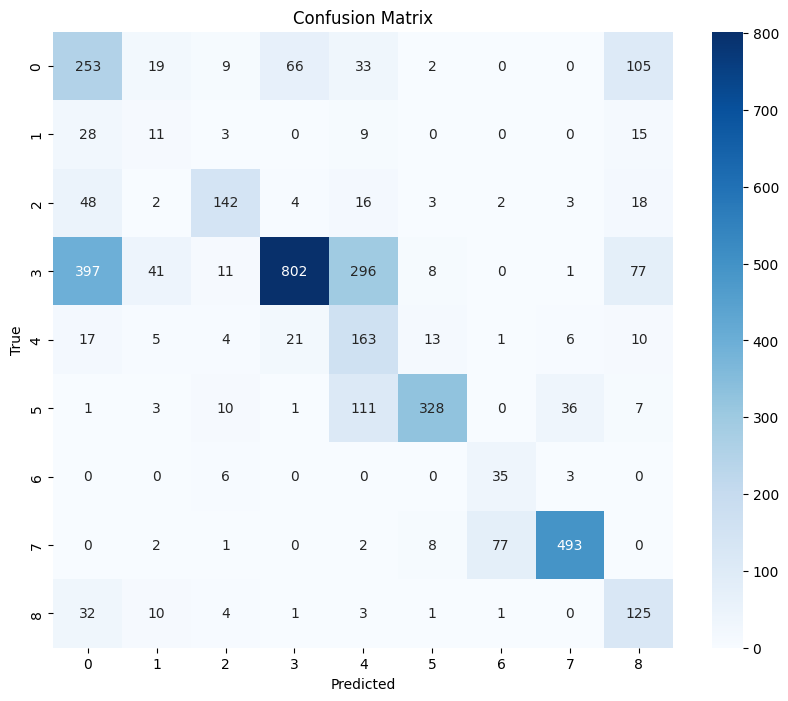

In [23]:
y_pred_lstm, y_true_lstm = get_preds_labels(StarTrack_LSTM_V1, val_loader_spect, device)

plot_confusion_matrix(y_true_lstm, y_pred_lstm)

In [16]:
torch.save(StarTrack_LSTM_V1.state_dict(), 'lstm_model_full.pth')

# Training The Fusion Branch

In [ ]:
class StarTrack_Fusion(nn.Module):
    def __init__(self, lstm_model: nn.Module, dense_model: nn.Module,
                 fused_hidden_dim=512, num_classes=9): 
        super().__init__()
        self.lstm_branch = lstm_model
        self.dense_branch = dense_model

        for param in self.lstm_branch.parameters():
            param.requires_grad = False
        for param in self.dense_branch.parameters():
            param.requires_grad = False
            
        for param in self.lstm_branch.fc1.parameters():
            param.requires_grad = True
        for param in self.dense_branch.fc1.parameters():
            param.requires_grad = True

        lstm_output_dim = 256
        dense_output_dim = 64
        
        self.cross_attn = nn.MultiheadAttention(embed_dim=lstm_output_dim, num_heads=4)
        self.fusion = nn.Sequential(
            nn.Linear(lstm_output_dim + dense_output_dim, fused_hidden_dim),
            nn.GELU(),  
            nn.BatchNorm1d(fused_hidden_dim),
            nn.Linear(fused_hidden_dim, fused_hidden_dim//2),
            nn.GELU(),
            nn.Dropout(0.3), 
            nn.Linear(fused_hidden_dim//2, num_classes)
        )
        
        self.lstm_classifier = nn.Linear(lstm_output_dim, num_classes)
        self.dense_classifier = nn.Linear(dense_output_dim, num_classes)
        self.dense_proj = nn.Linear(dense_output_dim, lstm_output_dim)

    def forward(self, lstm_input, dense_input):
            lstm_feat = self.lstm_branch.extract_features(lstm_input)
            dense_feat = self.dense_branch.extract_features(dense_input)
        
            lstm_q = lstm_feat.unsqueeze(0)  
            dense_kv = dense_proj.unsqueeze(0)  

            dense_proj = self.dense_proj(dense_feat) 
           
            attn_out, _ = self.cross_attn(query=lstm_q, key=dense_kv, value=dense_kv)
            attn_out = attn_out.squeeze(0)
        
            lstm_feat = lstm_feat + attn_out      
            fused = torch.cat([lstm_feat, dense_feat], dim=1) 
            out = self.fusion(fused)
        
            lstm_out = self.lstm_classifier(lstm_feat)
            dense_out = self.dense_classifier(dense_feat)
            return out, lstm_out, dense_out
